In [2]:
import numpy as np
import re
import pandas as pd
import math
from sodapy import Socrata
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from mpl_toolkits.basemap import Basemap

In [ ]:
client = Socrata("data.cityofnewyork.us", None)

results = client.get("h9gi-nx95", limit=2*10**6)

# Convert to pandas DataFrame
nypd_df = pd.DataFrame.from_records(results)

In [ ]:
nypd_df.to_pickle("./nypd.pkl")

In [4]:
nypd_df=pd.read_pickle("./nypd.pkl")

In [145]:
unique_list=nypd_df_2018["vehicle_type_code2"].unique().tolist()
unique_list=[str(s) for s in unique_list]
for string in unique_list:
    if re.findall("Bike|bike|cycle", string):
        print(string)

Motorcycle
Bike
Motorbike
Minicycle
Minibike


In [129]:
nypd_df_2018=nypd_df[nypd_df['crash_date'].str.contains("2018")]

In [141]:
bike_related_df=nypd_df_2018[(nypd_df_2018["vehicle_type_code1"]=="Bike") | (nypd_df_2018["vehicle_type_code2"]=="Bike")]

In [151]:
for column in bike_related_df:
    print(column)
    print(bike_related_df[column].unique())

crash_date
['2018-12-20T00:00:00.000' '2018-11-28T00:00:00.000'
 '2018-11-16T00:00:00.000' '2018-10-29T00:00:00.000'
 '2018-10-16T00:00:00.000' '2018-12-18T00:00:00.000'
 '2018-12-15T00:00:00.000' '2018-12-07T00:00:00.000'
 '2018-12-22T00:00:00.000' '2018-12-08T00:00:00.000'
 '2018-12-17T00:00:00.000' '2018-12-27T00:00:00.000'
 '2018-12-19T00:00:00.000' '2018-12-31T00:00:00.000'
 '2018-12-29T00:00:00.000' '2018-12-24T00:00:00.000'
 '2018-12-21T00:00:00.000' '2018-12-14T00:00:00.000'
 '2018-12-12T00:00:00.000' '2018-12-11T00:00:00.000'
 '2018-12-10T00:00:00.000' '2018-12-13T00:00:00.000'
 '2018-12-23T00:00:00.000' '2018-12-30T00:00:00.000'
 '2018-12-28T00:00:00.000' '2018-12-26T00:00:00.000'
 '2018-12-25T00:00:00.000' '2018-12-16T00:00:00.000'
 '2018-12-09T00:00:00.000' '2018-12-01T00:00:00.000'
 '2018-11-30T00:00:00.000' '2018-11-21T00:00:00.000'
 '2018-12-03T00:00:00.000' '2018-11-24T00:00:00.000'
 '2018-11-18T00:00:00.000' '2018-11-17T00:00:00.000'
 '2018-11-19T00:00:00.000' '2018-11

TypeError: unhashable type: 'dict'

C:\Users\PPawelec\AppData\Local\Temp\ipykernel_18808\3336722386.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['longitude']=df['longitude'].astype(float)
C:\Users\PPawelec\AppData\Local\Temp\ipykernel_18808\3336722386.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latitude']=df['latitude'].astype(float)


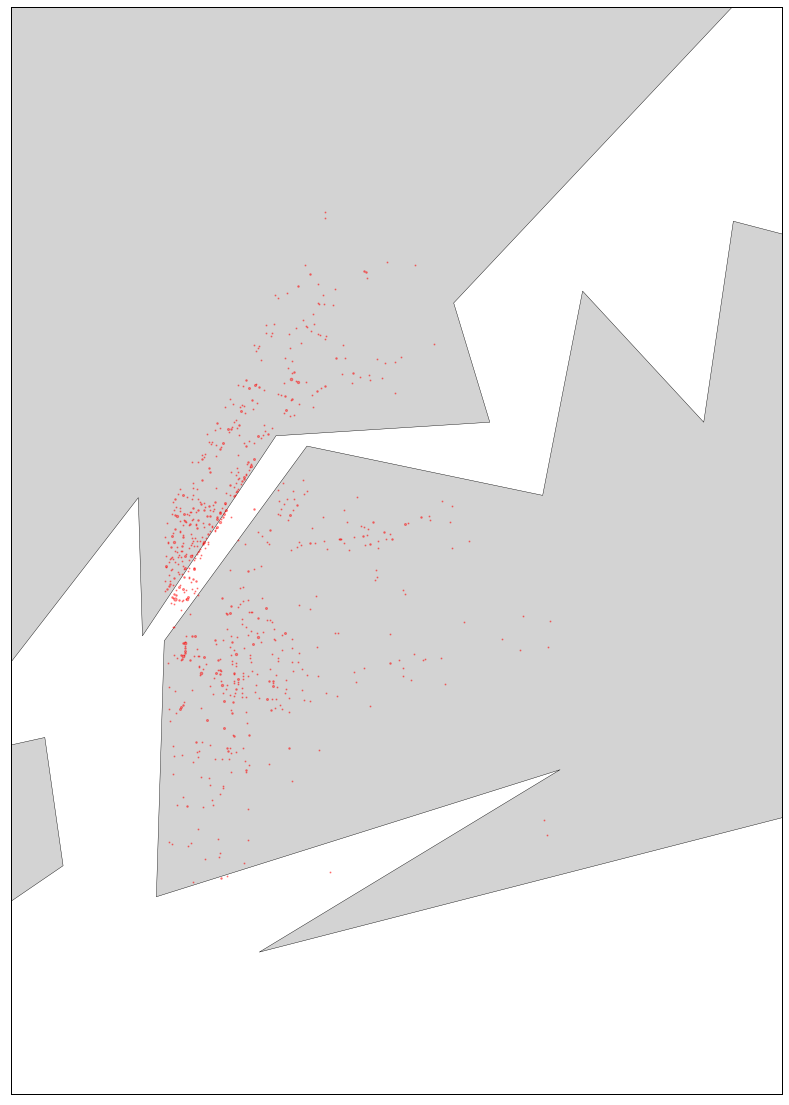

In [142]:
plot_map(bike_related_df, 0.1)

In [92]:
def plot_map(df, puffer):
    
    %matplotlib inline
    df=df[~df["longitude"].isnull()]
    df['longitude']=df['longitude'].astype(float)
    df['latitude']=df['latitude'].astype(float)
    df=df[df["latitude"]>40]
    df=df[df["latitude"]<41]
    df=df[df["longitude"]>-74]
    df=df[df["longitude"]<-70]
    df=df.groupby(["longitude", 'latitude'])["latitude"].agg('count').rename("count")
    df=df.to_frame().reset_index()
    lons = df['longitude'].values
    lats = df['latitude'].values
    count = df['count'].values
    
    puffer=puffer
    llcrnrlat=lats.min()-puffer
    urcrnrlat=lats.max()+puffer
    llcrnrlon=lons.min()-puffer
    urcrnrlon=lons.max()+puffer

    mpl.rcParams['figure.figsize'] = (20,20)
    m = Basemap(projection='merc',llcrnrlat=llcrnrlat,urcrnrlat=urcrnrlat,\
                llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon, resolution='l', area_thresh=50)
    #epsg = 2906,
    #m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 12000, verbose= True)
    m.drawmapboundary()
    m.drawcoastlines(color='black', linewidth=0.4)
    m.fillcontinents(color='lightgray')

    x,y = m(lons, lats)

    # r = red; o = circle marker (see: http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot)
    for x1, y1, c in zip(x, y, count):
        # markersize is scale down by /10
        # need alpha<1 to get some transparency
        # red color is more appropriate
        m.plot(x1, y1, 'ro', markersize=math.log(c,2), alpha=0.4)
    #m.plot(x, y, 'ro', markersize=5)
    plt.show()